# Simulated Annealing (SA)

Simulated Annealing (SA) is an optimization algorithm inspired by the **cooling process of metals**, where slow cooling results in a more structured and stable molecular arrangement. The algorithm mimics this process by carefully reducing a **temperature parameter ($T$)** over time while exploring potential solutions.

The two key parameters in SA are:
1. **Temperature ($T$)** – Controls the probability of accepting worse solutions.
2. **Cooling Rate ($\alpha$)** – Determines how quickly the temperature decreases.

- **Comparing Simulated Annealing (SA) with Greedy Stochastic (GS)**

    - **Greedy Stochastic (GS)**, a solution is only updated when an improvement is found, meaning the search **never** moves "uphill" (i.e., to a worse solution). 

    - SA, on the other hand, allows occasional uphill moves based on a probability function, helping escape local minima. The decision process follows:

        - **If the new solution is better** → Accept it.
        - **If the new solution is worse** → Accept it with probability $p$.

    - The probability of accepting an uphill move is given by:

\begin{equation}
p = \exp\left(\frac{-\Delta \text{Cost}}{T \cdot \alpha}\right)
\end{equation}

where $\Delta \text{Cost} = \text{Cost}(s_{\text{new}}) - \text{Cost}(s_{\text{current}})$. A larger $\Delta \text{Cost}$ means a lower chance of accepting the move. As temperature $T$ decreases over time, SA behaves more like GS.

---

## Steps in the Simulated Annealing Algorithm

### Initialization
- Start with an initial solution $s_0$.
- Set $s_{\text{current}} = s_0$ and $s_{\text{best}} = s_0$.
- Define:
    - The initial temperature $T_0$.
    - Cooling rate $\alpha$.
    - `max_iterations`.
    - The temperature is changed at every $M$ evaluations, and $M$ changes with time as $M=\beta M$.
      

### Iteration Process
Repeat until `max_iterations` is reached (**Metropolis Step**):

1. Select a **random neighbor** $s_{\text{new}}$ from the current solution's neighborhood.
2. Evaluate the cost function for $s_{\text{new}}$.
3. Decide whether to accept $s_{\text{new}}$:
   - If it has a **lower cost**, accept it.
   - If it has a **higher cost**, accept it with probability $p$.
4. If $s_{\text{new}}$ is better than $s_{\text{best}}$, update $s_{\text{best}}$.
5. Reduce the temperature: $T = \alpha T$.

---

## Choosing SA Parameters:
($T_0, \alpha, M,$ and `max_iterations`)

To balance exploration and exploitation, the initial temperature $T_0$ should allow a **moderate** acceptance of worse solutions, and over time, the probability of uphill moves should decrease.

The temperature at iteration $i$ follows:

\begin{equation}
T_i = \alpha^i T_0
\end{equation}

where $\alpha$ determines how fast the temperature drops. The choice of $T_0$ and $\alpha$ significantly affects performance.

### Estimating $T_0$
If we approximate the range of cost values as $R = \max(\text{Cost}) - \min(\text{Cost})$, then:

\begin{equation}
T_0 = -\frac{\Delta \text{Cost}_{\text{avg}}}{\ln p_1}
\end{equation}

where $p_1$ is the desired probability of accepting uphill moves early in the process.

### Estimating $\alpha$
At iteration $k$, the probability of accepting an uphill move should be $p_2$. Using:

\begin{equation}
\alpha = \left(\frac{\ln p_1}{\ln p_2}\right)^{\frac{1}{k}}
\end{equation}

we can adjust $\alpha$ to control the cooling schedule.



### Estimating $\Delta \text{Cost}_{\text{avg}}$

**Method 1**: No Evaluations
Assume the cost function is roughly uniform within a known range:

\begin{equation}
\Delta \text{Cost}_{\text{avg}} = \text{minCost} + 0.75 \times (\text{maxCost} - \text{minCost})
\end{equation}

**Method 2**: Use AP Evaluations for a More Refined Estimate
This approach still yields an approximation, but it's typically closer to the true value of $\Delta \text{Cost}_{\text{avg}}$, and it can also provide a better starting point $s_0$.

- Choose a starting point $s_1$ and evaluate $Cost(s_m)$ for $AP$ neighboring points $s_m \in N(s_1)$, where $m = 1, \ldots, AP$.
- Among the evaluated neighbors, select the one with the lowest cost to become the new starting point $s_0$.
- Estimate the average uphill cost difference using:

\begin{equation}
\Delta \text{Cost}_{\text{avg}} = \frac{1}{c} \sum_{j=1}^c \left( Cost(s_j) - Cost(s_0) \right)
\end{equation}

Where:
- $s_j$ are the neighboring states with higher cost than $s_0$
- $c$ is the number of such uphill neighbors

Neither method guarantees an optimal estimate of $T_0$, and their effectiveness can vary. Method 2 involves more computation, so your choice should depend on:
- How much information do you already have?
- How expensive it is to evaluate the cost function.
- How many total evaluations are allowed?

---

## Trade-offs in Parameter Selection

### Disadvantages of Large Parameter Estimation
- Reduces optimization runs by using resources for estimation.
- The estimated $T_0$ may not be valid for different regions of the search space.
- A very precise estimate of $T_0$ and $\alpha$ does not guarantee better results.

### Advantages of a Well-Chosen $T_0$
- A good estimate improves convergence speed.
- It helps avoid getting stuck in local minima too early.
- A reasonable trade-off is to use **AP < 5% of max_iterations**.

## Summary
- **Simulated Annealing** gradually reduces the probability of accepting worse solutions.
- **Proper tuning** of $T_0$ and $\alpha$ significantly impacts optimization efficiency.
- **Allows uphill moves** early in the search to escape local minima.
- **Behaves like Greedy Stochastic (GS)** as temperature approaches zero.

This approach is widely used in **combinatorial optimization problems** such as scheduling, traveling salesman problems, and machine learning hyperparameter tuning.


---


In [1]:
import numpy as np
from math import sin, cos, pi, exp, log
from random import randint, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from plotting_functions import pretty_plot_sa
np.random.seed(0)

# Exercise

Let's consider an optimization problem where we minimize the function:

\begin{equation}
f(s) = 10^9 - (625 - (s_1 - 25)^2) \cdot (1600 - (s_2 - 10)^2) \sin\left(\frac{s_1\pi}{10}\right) \cdot \sin\left(\frac{s_2\pi}{10}\right)
\end{equation}

for:

\begin{equation}
s = [s_1, s_2], \quad 0 \leq s_1, s_2 \leq 127, \quad s_1, s_2 \in \mathbb{N}.
\end{equation}

In [2]:
def cost_fs(S):
    return (10e9 - (625-(S[0]-25)**2) * (1600-(S[1]-10)**2) * sin(S[0]*pi/10) * sin(S[1]*pi/10))


- **Neighborhood Function**
    - Randomly perturb either $s_1$ or $s_2$ within $[s - 25, s + 25]$.
    - Ensure the new solution remains within the defined bounds $[0,127]$.
    - The new solution should not be identical to the current solution.

---

In [3]:
def random_neighbor_sa(S, min_value=0, max_value=127, delta=25):
    """
    Generates a new neighbor of the given solution by modifying one of its elements 
    within a specified range.
    
    Parameters:
        S (list): The current solution.
        min_value (int): The minimum possible value for an element in S (default is 0).
        max_value (int): The maximum possible value for an element in S (default is 127).
        delta (int): The maximum allowed change from the current value (default is 25).

    Returns:
        list: A new solution with one element modified.
    """
    
    # Create a copy of the current solution
    S_new = S.copy()
    
    # Select a random index to modify
    index = randint(0, len(S_new) - 1)
    
    # Generate a new value within the allowed range, ensuring it's different from the current value
    current_value = S_new[index]
    new_value = current_value
    while new_value == current_value:
        new_value = randint(max(current_value - delta, min_value), 
                            min(current_value + delta, max_value))
    
    # Update the selected index with the new value
    S_new[index] = new_value
    
    return S_new

- Define the GS algorithm from the Greed Search notebook. Remember:

**Greedy Stochastic** (GS)  
Here, the next value of $s$ is randomly selected from the neighbors of $s_{\text{current}}$.  
Unlike the deterministic approach, this allows for some exploration while still favoring local improvement.  


In [4]:
def GS(s_initial, max_iterations, cost_function):
    """
    Implements the Greedy Stochastic (GS) optimization algorithm.

    In this algorithm, the next value of 's' is randomly selected from 
    the neighbors of the best solution found so far. This introduces some 
    exploration while still favoring local improvement.

    Parameters:
        s_initial (int): The initial value of s.
        max_iterations (int): The maximum number of iterations to run the algorithm.
        cost_function (function): A function that computes the cost given an input s.

    Returns:
        np.ndarray: A matrix storing iteration number, current s, best s, 
                    current cost, and best cost for all iterations.
    """
    
    # Initialize the current solution and its cost
    curS = [s_initial.copy()]
    s_current = s_initial
    cost_current = cost_function(s_current)

    # Initialize the best solution and its cost
    s_best = s_current
    cost_best = cost_current

    # Create a matrix to store results (iteration, current cost, best cost)
    results_matrix = np.empty((max_iterations, 3))

    # Store initial values in the matrix
    results_matrix[0, :] = [0, cost_current, cost_best]

    # Loop through the maximum number of iterations
    for iteration in range(1, max_iterations):
        # Select a new solution randomly from the neighbors of the best solution found so far
        s_current = random_neighbor_sa(s_best)

        # Compute the cost of the new solution
        cost_current = cost_function(s_current)

        # If the new solution improves upon the best found so far, update best values
        if cost_current < cost_best:
            s_best = s_current
            cost_best = cost_current

        # Store the results for this iteration
        results_matrix[iteration, :] = [iteration, cost_current, cost_best]
        curS.append(s_current.copy())
    # Return the matrix containing the results of all iterations
    return results_matrix, s_best, np.array(curS)



- Define a Function that Performs a Simulated Annealing.

In [5]:
def simulated_annealing(initial_solution, initial_temperature, cooling_rate, reduction_factor, iterations_per_temp, max_iterations, cost_function, neighbor_function):
    """
    Performs Simulated Annealing (SA) to find an optimal solution.

    Parameters:
        initial_solution (array-like): Initial candidate solution.
        initial_temperature (float): Starting temperature for SA.
        cooling_rate (float): Factor by which temperature is reduced.
        reduction_factor (float): Reduction rate for iterations per temperature update.
        iterations_per_temp (int): Number of iterations before adjusting temperature.
        max_iterations (int): Maximum number of evaluations.
        cost_function (function): Function to evaluate the cost of a solution.
        neighbor_function (function): Function to generate a neighboring solution.

    Returns:
        tuple:
            - solution_history (numpy.ndarray): Array storing iteration, current cost, and best cost.
            - best_solution (array-like): Best solution found.
            - solution_trajectory (numpy.ndarray): Array of best solutions over time.
    """
    # Initialize the current solution with the provided initial solution

    
    # Set the best solution to be the initial solution

    
    # Compute the initial cost of the current solution

    
    # Initialize the best cost with the current cost

    
    # Create an array to store iteration number, current cost, and best cost

    
    # Create a list to store the trajectory of the best solution over time

    
    # Initialize the current temperature (renamed for clarity)

    
    # Initialize iteration counter

    
    # Run the SA algorithm until the max number of iterations is reached
    while iteration < max_iterations:
        # Perform the given number of iterations per temperature level
        for _ in range(max(1, int(iterations_per_temp))):
            # If max iterations are reached, exit the loop
            if iteration >= max_iterations:
                break
            
            # Store the current iteration, cost, and best cost in history

            
            # Save the current best solution to the trajectory

            
            # Generate a new solution by selecting a neighboring solution

            
            # Compute the cost of the new solution

            
            # Compute the cost difference between new and current solutions

            
            # Accept the new solution based on the Metropolis criterion
            if cost_difference < 0 or random() < exp(-cost_difference / current_temperature):
                # Update the current solution to the new one

                

                # Update the best solution if the new one is better
                if new_cost < best_cost:

                    

            # Increment iteration counter

                    
        # Reduce the temperature using the cooling rate

        
        # Reduce the number of iterations per temperature update

        
    # Return the solution history, best solution found, and solution trajectory
    return solution_history, best_solution, np.array(solution_trajectory)

- Test the function.

In [21]:
# Initialize parameters for the SA algorithm
#initial_solution = [randint(0, 127), randint(0, 127)]  # Random initial point in [0,127]^2
initial_solution = [20, 20]                           # Random initial point in [0,127]^2
initial_temperature = 1000                             # High enough to allow exploration
cooling_rate = 0.95                                     # Commonly used alpha (between 0.8–0.99)
reduction_factor = 0.99                                 # Reduce iterations per temp slightly
iterations_per_temp = 20                                # Start with 20 per temperature level
max_iterations = 1000                                   # Total number of iterations

# Call Simulated Annealing
history, best_sol, trajectory = simulated_annealing(
    initial_solution,
    initial_temperature,
    cooling_rate,
    reduction_factor,
    iterations_per_temp,
    max_iterations,
    cost_fs,
    random_neighbor_sa
)

# Show result
print("Best solution found:", best_sol)
print("Best cost:", cost_fs(best_sol))

Best solution found: [25, 5]
Best cost: 9999015625.0


- Define a function to precompute $T_0$ and $\alpha$ by calculating $\Delta \text{Cost}_{\text{avg}}$ with Method 1.

In [7]:
def estimate_sa_parameters(p1, p2, iterations, avg_cost_change=None, min_cost=None, max_cost=None):
    """
    Estimates the initial temperature (T0) and cooling rate (alpha) for Simulated Annealing.
    It computes the initial temperature (T0) and cooling rate (alpha) based on 
    provided probabilities (p1, p2) and cost changes. 

    Parameters:
        p1 (float): Initial probability of accepting an uphill move.
        p2 (float): Probability of accepting an uphill move after 'iterations' iterations.
        iterations (int): Number of iterations until SA should behave like Greedy Search.
        avg_cost_change (float, optional): Estimated average cost increase for uphill moves.
        min_cost (float, optional): Minimum cost in the search space.
        max_cost (float, optional): Maximum cost in the search space.

    Returns:
        tuple: (initial temperature T0, cooling rate alpha)
    """
    # Estimate avg cost change if not provided
    if avg_cost_change is None:
        avg_cost_change =  

    # Compute initial temperature using the probability of accepting an uphill move

    
    # Compute the cooling rate based on the expected reduction over iterations

    
    # Return the computed parameters
    return initial_temperature, cooling_rate


- Define a function to precompute $T_0$ and $\alpha$ by calculating $\Delta \text{Cost}_{\text{avg}}$ with Method 2.

In [8]:
def estimate_sa_parameters_with_samples(p1, p2, iterations, cost_function, num_samples=20, initial_point=None, neighbor_function=None):
    """
    Estimates SA parameters (T0, alpha) provided probabilities (p1, p2) and cost changes. 
    It samples the search space if needed, which can help in cases where a rough 
    estimate of the cost variation is desired.

    Parameters:
        p1 (float): Initial probability of accepting an uphill move.
        p2 (float): Probability of accepting an uphill move after 'iterations' iterations.
        iterations (int): Number of iterations until SA should behave like Greedy Search.
        cost_function (function): Cost function to evaluate solutions.
        num_samples (int): Number of samples for estimating cost variation.
        initial_point (array-like, optional): Starting point for sampling.
        neighbor_function (function, optional): Function to generate neighbors.

    Returns:
        tuple: (initial temperature T0, cooling rate alpha)
    """
    # If no initial point is provided, select a random starting point
    if initial_point is None:
        initial_point = 

    # Initialize list to store sampled solutions
    sampled_solutions = [initial_point]

    # Store the cost of the initial solution (as a list)

    
    # Generate additional samples to estimate cost variation
    for _ in range(num_samples):
        # Generate a neighboring solution

        
        # Store the new solution and its cost

        

    # Convert the sampled costs to a NumPy array for easy manipulation

    
    # Identify the best initial solution and its cost

    

    # Compute the average cost difference from the best initial solution

    
    # Compute the initial temperature using the probability of accepting an uphill move

    
    # Compute the cooling rate based on the expected reduction over iterations

    
    # Return the estimated parameters
    return initial_temperature, cooling_rate

- Run the simulated_annealing function with different parameters estimation. Below you can find a possible code for doing that, but do it as you wish:

In [9]:
def run_optimization(beta, M, maxIter, p1, p2, S0, cost_function, func_type):
    """
    Runs a single optimization method based on func_type.
    
    Parameters:
        beta (float): Reduction factor for iterations per temperature block (SA parameter).
        M (int): Initial iterations per temperature level (SA parameter).
        maxIter (int): Maximum number of iterations for the algorithm.
        p1 (float): Initial acceptance probability for an uphill move.
        p2 (float): Acceptance probability for an uphill move after a specified number of iterations.
        S0 (list): The initial solution (e.g., [x, y]).
        cost_function (function): Function to compute the cost of a given solution.
        func_type (str): Which optimization to run. Must be one of:
                         'GS' for Greedy Stochastic,
                         'SA_adap' for Simulated Annealing with adaptive parameters,
                         'SA_noadapt' for Simulated Annealing with non-adaptive parameters.
                         
    Returns:
        tuple: (log_matrix, best_solution, solution_trajectory) as returned by the corresponding method.
    """
    # If 'GS' is selected, run Greedy Stochastic search.
    if func_type == 'GS':
        # Run GS starting from S0 for maxIter iterations.
        GS_mat, GS_best, GS_curS = GS(S0, maxIter, cost_function)
        # Print the starting and best solution.
        print("Initial s: {}  |  Best s by Greedy Search: {}".format(S0, GS_best))
        return GS_mat, GS_best, GS_curS

    # If 'SA_adap' is selected, run Simulated Annealing with adaptive parameter estimation.
    elif func_type == 'SA_adap':
        # Estimate SA parameters using adaptive sampling (with cost_function and random_neighbor_sa).
        T0, alpha = estimate_sa_parameters_with_samples(p1, p2, 1000, cost_function, neighbor_function=random_neighbor_sa)
        # Run SA (adaptive) starting from S0.
        SA_mat, SA_best, SA_curS = simulated_annealing(S0, T0, alpha, beta, M, maxIter, cost_function, random_neighbor_sa)
        print("Initial s: {}  |  Best s by Simulated Annealing with AP: {}".format(S0, SA_best))
        return SA_mat, SA_best, SA_curS

    # If 'SA_noadapt' is selected, run Simulated Annealing with non-adaptive parameter estimation.
    elif func_type == 'SA_noadapt':
        # Estimate SA parameters without adaptive sampling using provided cost bounds.
        T0_noAP, alpha_noAP = estimate_sa_parameters(p1, p2, 1000, min_cost=0.99e10, max_cost=1.0e10)
        # Run SA (non-adaptive) starting from S0.
        SA_mat_noAP, SA_best_noAP, SA_curS_noAP = simulated_annealing(S0, T0_noAP, alpha_noAP, beta, M, maxIter, cost_function, random_neighbor_sa)
        print("Initial s: {}  |  Best s by Simulated Annealing without AP: {}".format(S0, SA_best_noAP))
        return SA_mat_noAP, SA_best_noAP, SA_curS_noAP

    # If an invalid func_type is provided, print an error message.
    else:
        print("Invalid function type provided. Please choose 'GS', 'SA_adap', or 'SA_noadapt'.")
        return None


In [10]:
# Define algorithm parameters.
beta = 1             # Reduction factor for iterations per temperature block.
M = 1                # Initial iterations per temperature level.
maxIter = 1100       # Maximum number of iterations.
p1, p2 = 0.9, 0.05   # Acceptance probabilities for uphill moves.

# Generate an initial solution randomly within the allowed range.
#S0 = [randint(0, 127), randint(0, 127)]
S0 = [20, 20]

# Run one of the optimizations, e.g., Greedy Stochastic search.
GS_mat, GS_best, GS_curS = run_optimization(beta, M, maxIter, p1, p2, S0, cost_fs, 'GS')

# Or run Simulated Annealing with adaptive parameters.
SA_mat, SA_best, SA_curS = run_optimization(beta, M, maxIter, p1, p2, S0, cost_fs, 'SA_adap')

# Or run Simulated Annealing with non-adaptive parameters.
SA_mat_noAP, SA_best_noAP, SA_curS_noAP = run_optimization(beta, M, maxIter, p1, p2, S0, cost_fs, 'SA_noadapt')


Initial s: [20, 20]  |  Best s by Greedy Search: [20, 20]
Initial s: [20, 20]  |  Best s by Simulated Annealing with AP: [115, 115]
Initial s: [20, 20]  |  Best s by Simulated Annealing without AP: [116, 115]


- Some plots of the solutions:

In [11]:
def plot_simulation_results(S0, maxIter, sim_outputs):
    """
    Plots the cost surface, solution trajectories, and cost histories for three simulation outputs.
    
    Parameters:
        S0 (list): The initial solution (e.g., [x, y]).
        maxIter (int): Maximum number of iterations used in the simulations (for x-axis limits).
        sim_outputs (tuple/list): A tuple (or list) containing three simulation outputs in this order:
            (GS_mat, GS_best, GS_curS),
            (SA_mat, SA_best, SA_curS), and
            (SA_mat_noAP, SA_best_noAP, SA_curS_noAP).
    
    The function uses the global cost function 'cost_fs' and assumes a grid limit of 128.
    """
    # Unpack the three simulation outputs.
    GS_mat, GS_best, GS_curS = sim_outputs[0]
    SA_mat, SA_best, SA_curS = sim_outputs[1]
    SA_mat_noAP, SA_best_noAP, SA_curS_noAP = sim_outputs[2]
    
    # Create a grid of coordinate pairs for the cost surface.
    limS = 128  # Grid limit in each dimension.
    S_grid = np.array([[(i, j) for i in range(limS)] for j in range(limS)], dtype=np.dtype('int,int'))
    
    # Vectorize the cost function so it can be applied elementwise to the grid.
    vect_cost = np.vectorize(cost_fs)
    # Compute the cost for each coordinate pair in the grid.
    S_cost = vect_cost(S_grid)
    
    # Create a figure with 1 row and 2 columns of subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --------------------- Left subplot: Cost Surface and Trajectories ---------------------
    ax1.imshow(S_cost, cmap='PiYG', origin='lower')  # Display the cost surface with origin at lower left.
    ax1.plot(GS_curS[:, 0], GS_curS[:, 1], label='GS')  # Overlay GS trajectory.
    ax1.plot(SA_curS[:, 0], SA_curS[:, 1], label='SA')  # Overlay SA (adaptive) trajectory.
    ax1.plot(SA_curS_noAP[:, 0], SA_curS_noAP[:, 1], label='SA_noAP')  # Overlay SA (non-adaptive) trajectory.
    # Mark the starting solution.
    ax1.scatter([S0[0]], [S0[1]], s=50, c='b', linewidths=3, label='Start')
    # Mark the final best solutions from each simulation.
    ax1.scatter([GS_best[0]], [GS_best[1]], s=50, marker='x', linewidths=3, label='GS Final')
    ax1.scatter([SA_best[0]], [SA_best[1]], s=50, marker='x', linewidths=3, label='SA Final')
    ax1.scatter([SA_best_noAP[0]], [SA_best_noAP[1]], s=50, marker='x', linewidths=3, label='SA_noAP Final')
    ax1.set_xlabel('S1')  # Label x-axis.
    ax1.set_ylabel('S2')  # Label y-axis.
    ax1.set_title('Movement along Cost Function')  # Set subplot title.
    ax1.legend()  # Add a legend.
    
    # --------------------- Right subplot: Cost History ---------------------
    # Plot GS cost history: iteration (column 0) vs. best cost (column 2).
    ax2.plot(GS_mat[:, 0], GS_mat[:, 2], label='GS')
    # Plot SA (adaptive) cost history.
    ax2.plot(SA_mat[:, 0], SA_mat[:, 2], label='SA')
    # Plot SA (non-adaptive) cost history.
    ax2.plot(SA_mat_noAP[:, 0], SA_mat_noAP[:, 2], label='SA_noAP')
    ax2.set_xlim(0, maxIter)  # Set x-axis limits.
    ax2.set_xlabel('Iteration')  # Label x-axis.
    ax2.set_ylabel('Cost')  # Label y-axis.
    ax2.set_title('Comparison of Algorithms')  # Set subplot title.
    ax2.legend()  # Add a legend.
    
    plt.tight_layout()  # Adjust subplots to fit neatly within the figure.
    plt.show()  # Display the figure.


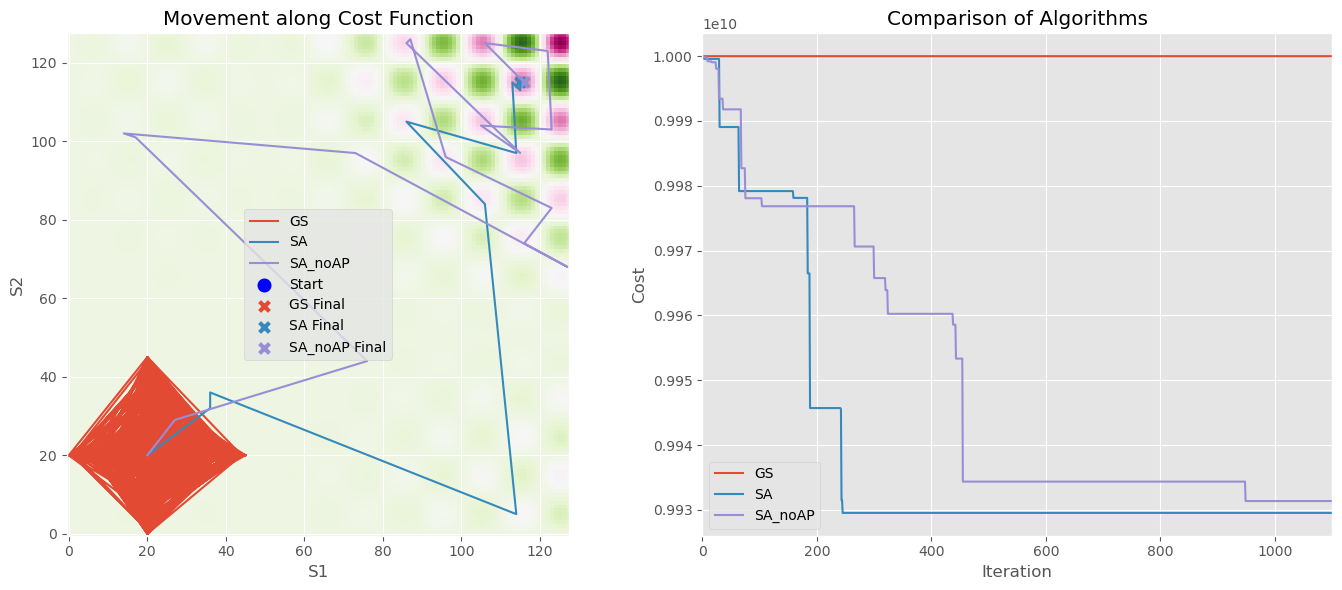

In [12]:
# Example simulation outputs from your runs:
sim_GS = (GS_mat, GS_best, GS_curS)
sim_SA_adap = (SA_mat, SA_best, SA_curS)
sim_SA_noadapt = (SA_mat_noAP, SA_best_noAP, SA_curS_noAP)

# Call the plotting function with S0, maxIter, and a tuple/list of three simulation outputs.
plot_simulation_results(S0, maxIter, (sim_GS, sim_SA_adap, sim_SA_noadapt))


- Now we repeat the process but we simulate more times and we represent the average values of the simulations.

In [16]:
# Number of simulations to run
numSim = 30
limS = 128  # Grid limit for generating random starting solutions


# Define algorithm parameters.
beta = 1             # Reduction factor for iterations per temperature block.
M = 1                # Initial iterations per temperature level.
maxIter = 1100       # Maximum number of iterations.
p1, p2 = 0.9, 0.05   # Acceptance probabilities for uphill moves.
S0 = [20, 20]

# Estimate SA parameters without adaptive sampling using provided cost bounds.
T0_noAP, alpha_noAP = estimate_sa_parameters(p1, p2, 1000, min_cost=0.99e10, max_cost=1.0e10)

# Estimate SA parameters with adaptive sampling using provided cost bounds.
T0, alpha = estimate_sa_parameters_with_samples(p1, p2, 1000, cost_fs, neighbor_function=random_neighbor_sa)

# Preallocate arrays to store simulation outputs for each method.
# GS outputs: GS_mat is (maxIter x 3), GS_best is a vector of length 2, GS_curS is (maxIter x 2)
GS_matV   = np.empty((numSim, maxIter, 3))
GS_bestV  = np.empty((numSim, 2))
GS_curSV  = np.empty((numSim, maxIter, 2))

# SA with adaptive parameters outputs.
SA_matV   = np.empty((numSim, maxIter, 3))
SA_bestV  = np.empty((numSim, 2))
SA_curSV  = np.empty((numSim, maxIter, 2))

# SA with non-adaptive parameters outputs.
SAnoAP_matV   = np.empty((numSim, maxIter, 3))
SAnoAP_bestV  = np.empty((numSim, 2))
SAnoAP_curSV  = np.empty((numSim, maxIter, 2))

# Run the simulations.
for i in range(numSim):
    
    # Run Greedy Stochastic search.
    # GS expects inputs: starting solution S0, maxIter, and the cost function.
    GS_mat, GS_best, GS_curS = GS(S0, maxIter, cost_fs)
    GS_matV[i] = GS_mat             # Store GS log matrix.
    GS_bestV[i] = GS_best           # Store GS final best solution.
    GS_curSV[i] = GS_curS           # Store GS trajectory.
    
    # Run Simulated Annealing with adaptive parameters.
    # simulated_annealing expects: S0, T0, alpha, beta, M, maxIter, cost_fs, random_neighbor_sa.


    SA_mat, SA_best, SA_curS = simulated_annealing(S0, T0, alpha, beta, M, maxIter, cost_fs, random_neighbor_sa)
    SA_matV[i] = SA_mat
    SA_bestV[i] = SA_best
    SA_curSV[i] = SA_curS
    
    # Run Simulated Annealing with non-adaptive parameters.
    SAnoAP_mat, SAnoAP_best, SAnoAP_curS = simulated_annealing(S0, T0_noAP, alpha_noAP, beta, M, maxIter, cost_fs, random_neighbor_sa)
    SAnoAP_matV[i] = SAnoAP_mat
    SAnoAP_bestV[i] = SAnoAP_best
    SAnoAP_curSV[i] = SAnoAP_curS

# After running all simulations, compute the average best cost for each method.
# We assume that the cost function (cost_fs) returns a scalar cost for a given solution.
avg_GS_cost   = np.mean([cost_fs(GS_bestV[i]) for i in range(numSim)])
avg_SA_cost   = np.mean([cost_fs(SA_bestV[i]) for i in range(numSim)])
avg_SAnoAP_cost = np.mean([cost_fs(SAnoAP_bestV[i]) for i in range(numSim)])

print("Average best cost by GS:         ", avg_GS_cost)
print("Average best cost by SA (adaptive):", avg_SA_cost)
print("Average best cost by SA (non-adaptive):", avg_SAnoAP_cost)

Average best cost by GS:          10000000000.0
Average best cost by SA (adaptive): 9909045902.973148
Average best cost by SA (non-adaptive): 9926759963.252842


In [14]:
def plot_average_results(GS_curSV, SA_curSV, SAnoAP_curSV, GS_matV, SA_matV, SAnoAP_matV, maxIter, cost_fs):
    """
    Plots the cost surface, averaged trajectories, and averaged cost histories for three simulation outputs.
    
    Parameters:
        GS_curSV (ndarray): Array of GS trajectories with shape (numSim, maxIter, 2)
        SA_curSV (ndarray): Array of SA adaptive trajectories with shape (numSim, maxIter, 2)
        SAnoAP_curSV (ndarray): Array of SA non-adaptive trajectories with shape (numSim, maxIter, 2)
        GS_matV (ndarray): Array of GS cost log matrices with shape (numSim, maxIter, 3)
        SA_matV (ndarray): Array of SA adaptive cost log matrices with shape (numSim, maxIter, 3)
        SAnoAP_matV (ndarray): Array of SA non-adaptive cost log matrices with shape (numSim, maxIter, 3)
        maxIter (int): Maximum number of iterations.
        cost_fs (function): The cost function used to generate the cost surface.
    """
    # --- Compute the cost surface ---
    limS = 128  # Grid limit in each dimension.
    # Create a grid of coordinate pairs (i, j).
    S_grid = np.array([[(i, j) for i in range(limS)] for j in range(limS)], dtype=np.dtype('int,int'))
    # Vectorize the cost function so it can be applied elementwise.
    vect_cost = np.vectorize(cost_fs)
    # Compute the cost at each grid point.
    S_cost = vect_cost(S_grid)
    
    # --- Create the figure with 1 row and 2 columns of subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --------------------- Left subplot: Cost Surface and Averaged Trajectories ---------------------
    # Store the image returned by imshow so we can attach a colorbar.
    im = ax1.imshow(S_cost, cmap='PiYG', origin='lower')  # Display the cost surface.
    
    # Average trajectories for GS.
    avg_GS_x = np.average(GS_curSV[:,:,0], axis=0)
    avg_GS_y = np.average(GS_curSV[:,:,1], axis=0)
    ax1.plot(avg_GS_x, avg_GS_y, label='GS')
    
    # Average trajectories for SA adaptive.
    avg_SA_x = np.average(SA_curSV[:,:,0], axis=0)
    avg_SA_y = np.average(SA_curSV[:,:,1], axis=0)
    ax1.plot(avg_SA_x, avg_SA_y, label='SA')
    
    # Average trajectories for SA non-adaptive.
    avg_SAnoAP_x = np.average(SAnoAP_curSV[:,:,0], axis=0)
    avg_SAnoAP_y = np.average(SAnoAP_curSV[:,:,1], axis=0)
    ax1.plot(avg_SAnoAP_x, avg_SAnoAP_y, label='SA no AP')
    
    ax1.set_xlabel('S1')  # Label x-axis.
    ax1.set_ylabel('S2')  # Label y-axis.
    ax1.set_title('Movement along Cost Function')  # Set subplot title.
    ax1.legend()  # Add legend.
    # Use the mappable (im) returned by imshow to add a colorbar.
    plt.colorbar(im, ax=ax1)
    
    # --------------------- Right subplot: Averaged Cost Histories ---------------------
    # Use the iteration values from the first simulation (assumed identical for all).
    iter_axis = GS_matV[0,:,0]
    
    # Average best cost for GS across simulations.
    avg_GS_cost = np.average(GS_matV[:,:,2], axis=0)
    ax2.plot(iter_axis, avg_GS_cost, label='GS')
    
    # Average best cost for SA adaptive.
    avg_SA_cost = np.average(SA_matV[:,:,2], axis=0)
    ax2.plot(SA_matV[0,:,0], avg_SA_cost, label='SA')
    
    # Average best cost for SA non-adaptive.
    avg_SAnoAP_cost = np.average(SAnoAP_matV[:,:,2], axis=0)
    ax2.plot(SAnoAP_matV[0,:,0], avg_SAnoAP_cost, label='SA no AP')
    
    ax2.set_xlim(0, maxIter)  # Set x-axis limits.
    ax2.set_xlabel('Iteration')  # Label x-axis.
    ax2.set_ylabel('Cost')  # Label y-axis.
    ax2.set_title('Comparison of Algorithms')  # Set subplot title.
    ax2.legend()  # Add legend.
    
    plt.tight_layout()  # Adjust layout.
    plt.show()  # Display the figure.


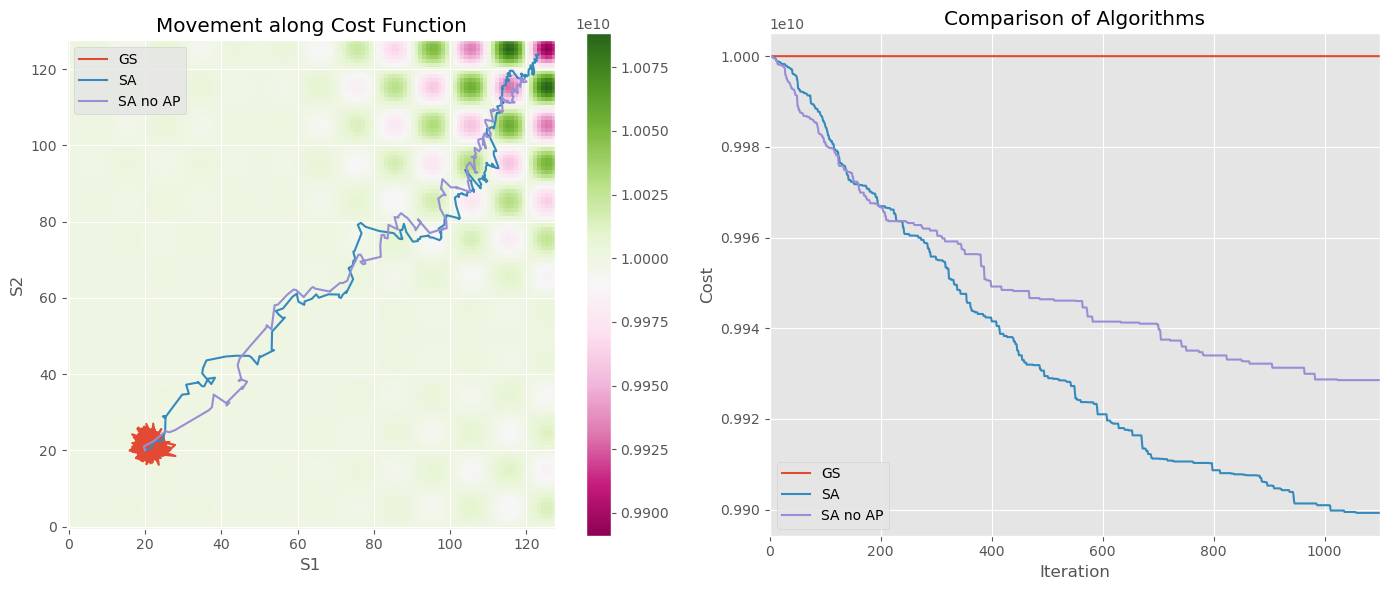

In [15]:
plot_average_results(GS_curSV, SA_curSV, SAnoAP_curSV, GS_matV, SA_matV, SAnoAP_matV, maxIter, cost_fs)
